# Race

In [1]:
import fastf1
import fastf1.plotting
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl.styles import PatternFill
from openpyxl import Workbook
from openpyxl import load_workbook
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
from scipy.interpolate import make_interp_spline
from fastf1 import utils
from statistics import mean 
from scipy import stats

# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

In [2]:
ses = 5
race = 18

In [3]:
session = fastf1.get_session(2023,race,ses)
session.load()
fastf1.Cache.enable_cache('cache') 

req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\GTR\AppData\Local\Temp\fastf1.
	Size: 344.32 MB


core           INFO 	Loading data for United States Grand Prix - Race [v3.1.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core        WARNING 	Session results contain duplicate entries for driver(s) ['22']
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '55', '11', '63', '10', '18', '22', '23', '2', '27', '77', '24', '20', '3', '1

In [4]:
session.results

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points
1,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671C6,red_bull,Max,Verstappen,Max Verstappen,...,NED,1.0,1,6.0,NaT,NaT,NaT,0 days 01:35:21.362000,Finished,25.0
4,4,L NORRIS,NOR,norris,McLaren,F58020,mclaren,Lando,Norris,Lando Norris,...,GBR,2.0,2,2.0,NaT,NaT,NaT,0 days 00:00:10.730000,Finished,18.0
55,55,C SAINZ,SAI,sainz,Ferrari,F91536,ferrari,Carlos,Sainz,Carlos Sainz,...,ESP,3.0,3,4.0,NaT,NaT,NaT,0 days 00:00:15.134000,Finished,15.0
11,11,S PEREZ,PER,perez,Red Bull Racing,3671C6,red_bull,Sergio,Perez,Sergio Perez,...,MEX,4.0,4,9.0,NaT,NaT,NaT,0 days 00:00:18.460000,Finished,12.0
63,63,G RUSSELL,RUS,russell,Mercedes,6CD3BF,mercedes,George,Russell,George Russell,...,GBR,5.0,5,5.0,NaT,NaT,NaT,0 days 00:00:24.999000,Finished,10.0
10,10,P GASLY,GAS,gasly,Alpine,2293D1,alpine,Pierre,Gasly,Pierre Gasly,...,FRA,6.0,6,7.0,NaT,NaT,NaT,0 days 00:00:47.996000,Finished,8.0
18,18,L STROLL,STR,stroll,Aston Martin,358C75,aston_martin,Lance,Stroll,Lance Stroll,...,CAN,7.0,7,0.0,NaT,NaT,NaT,0 days 00:00:48.696000,Finished,6.0
22,22,Y TSUNODA,TSU,tsunoda,AlphaTauri,5E8FAA,alphatauri,Yuki,Tsunoda,Yuki Tsunoda,...,JPN,8.0,8,11.0,NaT,NaT,NaT,0 days 00:01:14.385000,Finished,5.0
23,23,A ALBON,ALB,albon,Williams,37BEDD,williams,Alexander,Albon,Alexander Albon,...,THA,9.0,9,15.0,NaT,NaT,NaT,0 days 00:01:26.714000,Finished,2.0
2,2,L SARGEANT,SAR,sargeant,Williams,37BEDD,williams,Logan,Sargeant,Logan Sargeant,...,USA,10.0,10,16.0,NaT,NaT,NaT,0 days 00:01:27.998000,Finished,1.0


In [5]:
session_Sprint = fastf1.get_session(2023,race,4)
session_Sprint.load()
fastf1.Cache.enable_cache('cache')

core           INFO 	Loading data for United States Grand Prix - Sprint [v3.1.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '4', '11', '55', '10', '63', '23', '81', '31', '3', '14', '22', '27', '77', '24', '20', '2', '18']


### Pre defined

In [6]:
def Safety_car(df):
    """Extracts intervals from a DataFrame and adds +1 to the second couple if the two elements are equal.

    Args:
        df: A DataFrame containing the data to extract intervals from.

    Returns:
        A list of intervals, where each interval is a tuple of (start, end).
    """

    # Initialize the list of intervals
    intervals = []

    # Iterate over the rows in the DataFrame
    for i in range(len(df)):

        # Check if the current row is the start of a new interval
        if i == 0 or df.iloc[i, 0] != df.iloc[i - 1, 0] + 1:

            # Add the new interval to the list
            intervals.append([df.iloc[i, 0],df.iloc[i, 0]])

        # Update the end of the current interval
        intervals[-1] = (intervals[-1][0], df.iloc[i, 0])

    # Loop over the intervals and check if the couples of intervals need +1 for the second couple
    for i in range(len(intervals)):
        if intervals[i][0] == intervals[i][1]:
            # Convert the interval tuple to a list
            interval_list = list(intervals[i])

            # Update the value of the second element in the list
            interval_list[1] = interval_list[1] + 1

            # Convert the list back to a tuple
            intervals[i] = tuple(interval_list)

    return intervals
# Set display options to show all columns
pd.set_option('display.max_columns', None)

def calculate_delta_times(df_lap, df_reference):
    """Calculates the delta times for a given lap, relative to a reference lap.

    Args:
    lap_data: A numpy array containing the lap data. The lap data should be in the
        form of a 2D array, where the first column is the distance and the second
        column is the time.
    reference_lap_data: A numpy array containing the reference lap data. The
        reference lap data should be in the same format as the lap data.

    Returns:
    A numpy array containing the delta times.
    """
    # # Add attribute TimeS to the dataframe
    df_lap["TimeS"] = df_lap["Time"].dt.total_seconds()
    df_reference["TimeS"] = df_reference["Time"].dt.total_seconds()

    # # Stretch or contract the distances across all the data objects so that the total
    # # distance of the lap matches the fastest (reference) lap in the selection.
    df_lap["Distance"] = df_lap["Distance"] * (df_reference.iloc[-1]["Distance"] / df_lap.iloc[-1]["Distance"])
    # Use linear interpolation to align each data object with the data objects in
    # the fastest lap.

    interp_lap_data = np.interp(df_lap["Distance"], df_reference["Distance"],df_reference["TimeS"])
    # Return the difference in time at each instance.
    delta_times =  interp_lap_data.tolist() - df_lap["TimeS"]

    return delta_times, df_lap["Distance"]

def SectorDistance(laps):

    sector_time = []
    sector_distance = []
    lap = laps.pick_fastest()
    for i in range(3):
        sector_time.append(lap["Sector"+str(i+1)+"Time"])
    for i in range(2):
        sector_time[i+1] = sector_time[i] + sector_time[i+1]
    lap_telemetry = lap.get_telemetry()
    sector_distance.append(lap_telemetry.loc[lap_telemetry["Time"] <= sector_time[0],"Distance"].max())
    sector_distance.append(lap_telemetry.loc[lap_telemetry["Time"] <= sector_time[1],"Distance"].max())
    sector_distance.append(lap_telemetry["Distance"].max())
    return sector_distance
    
def SectorLocation(laps):

    sector_location = [[],[]]
    sector_distance = SectorDistance(laps)
    comp = laps.pick_fastest().get_telemetry()
    comp = comp [["X","Y","Distance"]]
    for i in sector_distance:
        Sec = comp
        Sec["MinDis"] = (Sec["Distance"] - i).abs()
        sec_loc = Sec.loc[Sec["MinDis"]==Sec["MinDis"].min(),["X","Y"]].values[0]
        sector_location[0].append(sec_loc[0]) # Append X
        sector_location[1].append(sec_loc[1]) # Append Y
    return sector_location

In [7]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

compoundcolor = pd.DataFrame.from_dict(
    {
        1: ['HARD','#F0F0EC'], 
        2:['INTERMEDIATE', '#43B02A'], 
        3:['MEDIUM','#FFD12E'], 
        4:['SOFT', '#DA291C'], 
        5:['TEST-UNKNOWN', '#434649'], 
        6:['UNKNOWN','#00FFFF'], 
        7:['WET', '#0067AD']
    },
    orient='index',
    columns=['Compound', 'CompoundColor']
)

In [8]:
# getting laps of session
laps = session.laps 

# Cleaning laps data
a = laps[(laps['LapTime'].isna())&(laps['LapNumber'] != 1)&(laps['Sector1Time'].notna())] 
a["LapTime"] = a["Sector1Time"] + a["Sector2Time"] + a["Sector3Time"]
laps[(laps['LapTime'].isna())&(laps['LapNumber'] != 1)&(laps['Sector1Time'].notna())] = a

# adding lap time in seconds
laps['LapTimeS'] = laps["LapTime"].dt.total_seconds()

# adding lap time start in seconds
laps['LapStartTimeS'] = laps["LapStartTime"].dt.total_seconds()

# adding lap time finish in seconds
laps['LapFinishTimeS'] = laps["LapStartTimeS"] + laps["LapTimeS"]

# adding lap time end in seconds
laps['DeltaTime'] = 0 # add column Delta time filled with 0

# adding missing data to first lap
laps.loc[laps["LapNumber"] == 1,['LapFinishTimeS']] = laps.loc[laps["LapNumber"] == 2,["LapStartTimeS"]].values

# getting max lap of session
max_lap_race = int(session.laps["LapNumber"].max())

#results of race
results = session.results
results = results.sort_values(by=['Position'])

#correcting team color
results["TeamColor"] = [fastf1.plotting.team_color(i) for i in results["TeamName"]] 

# drivers list
drivers = results["DriverNumber"].values
# drivers =['1', '81', '4', '63', '16', '14', '31', '77', '24', '11', '18', '10', '23', '20', '22', '27', '40', '2', '44']

# Drivers Start order 
drivers_start = results[["DriverNumber","GridPosition"]].sort_values(by=['GridPosition'])
drivers_start = drivers_start["DriverNumber"].values

#drivers abreviation
drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

# Drivers Start order 
drivers_start_abr = results[["Abbreviation","GridPosition"]].sort_values(by=['GridPosition'])
drivers_start_abr = drivers_start_abr["Abbreviation"].values

#race name 
race_name = session.event["EventName"]
session_name = session.event["Session"+str(ses)]
corners_distance = session.get_circuit_info().corners
sector_distance = SectorDistance(laps)
sector_location = SectorLocation(laps)

In [9]:
DRIVERS = []
for i in range(1,max_lap_race+1):
    lap = laps.loc[laps["LapNumber"]== max_lap_race+1-i].sort_values(by=["LapFinishTimeS"],ascending=True).reset_index(drop=True)
    for j in range(0,len(lap)):
        if lap.iloc[j]["DriverNumber"] not in DRIVERS:
            DRIVERS.append(lap.iloc[j]["DriverNumber"] )


In [10]:
if((DRIVERS == drivers.tolist())):
    print("same order")
else:
    DRV = pd.DataFrame()
    DRV["DriverNumber"] = DRIVERS
    results = pd.merge(DRV, results, on='DriverNumber')
    # drivers list
    drivers = results["DriverNumber"].values

    # Drivers Start order 
    drivers_start = results[["DriverNumber","GridPosition"]].sort_values(by=['GridPosition'])
    drivers_start = drivers_start["DriverNumber"].values

    #drivers abreviation
    drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

    # Drivers Start order 
    drivers_start_abr = results[["Abbreviation","GridPosition"]].sort_values(by=['GridPosition'])
    drivers_start_abr = drivers_start_abr["Abbreviation"].values
    print("The list was reorganized")


The list was reorganized


### Race order

### Gap to race winner graph

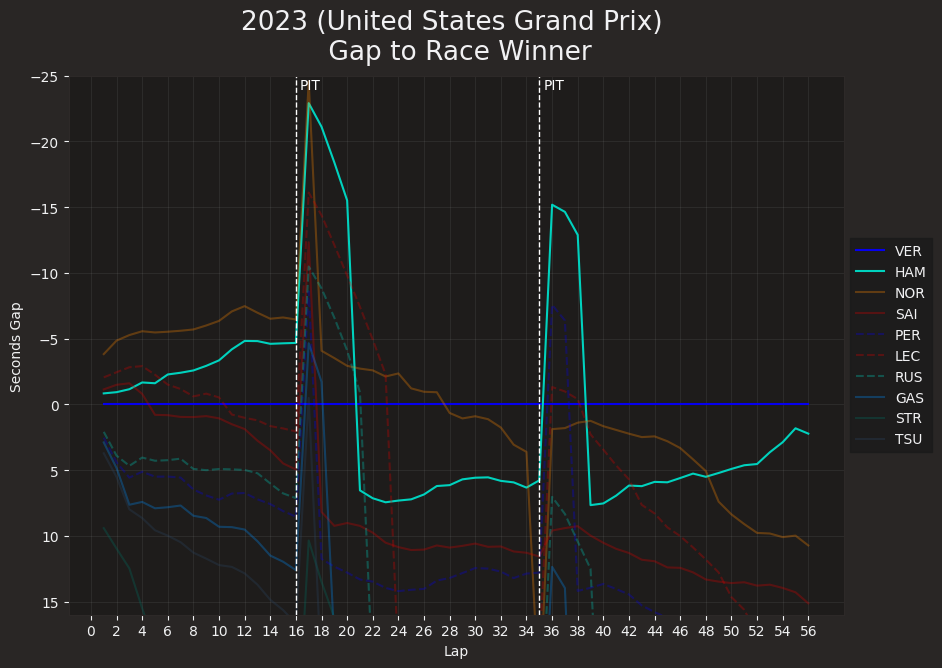

In [11]:
#getting the winner 
winner = drivers[0]

# getting pit in lap
pitin = laps.pick_driver(1).dropna(subset=['PitInTime'])["LapNumber"]

#making a new variable called delta_time which contain all laps with limited columns 
delta_time = laps[["DriverNumber","Driver","LapNumber","LapStartTime","LapFinishTimeS","DeltaTime"]] 
delta_time = delta_time.dropna(subset=['LapFinishTimeS'])
# loop to calculate race gap to race winner
for i in drivers:
    #calculate the difference between race winner and other drivers on the laps Start Time Seconds 
    gap = delta_time.loc[delta_time["DriverNumber"] == i,["LapFinishTimeS"]].reset_index() - delta_time.loc[delta_time["DriverNumber"] == winner,["LapFinishTimeS"]].reset_index()
    #Drop NAN values
    gap = gap.dropna(subset=['LapFinishTimeS'])
    #affect a list of gap values to the driver on the column DeltaTime which was 0 
    delta_time.loc[delta_time["DriverNumber"] == i, "DeltaTime"] = gap["LapFinishTimeS"].values # list of gap for all laps 

#loading data    
safetycardata = laps.pick_driver(winner)
#loading only safety car laps
safetycar = safetycardata.loc[safetycardata["TrackStatus"].str.contains('4'),['LapNumber','TrackStatus']].reset_index(drop=True)
#loading only Virstual safety car laps
Vsafetycar = safetycardata.loc[safetycardata["TrackStatus"].str.contains('6'),['LapNumber','TrackStatus']].reset_index(drop=True)

# Plot the graph

plt.figure(figsize=(10, 7))
color_picked = []
drivers_selected = ['1','44']
max_gap = 0
min_gap = 0
for i in drivers[:10]:
# for i in drivers:
    x = delta_time.loc[delta_time["DriverNumber"]==i,"LapNumber"]
    y = delta_time.loc[delta_time["DriverNumber"]==i,"DeltaTime"]
    driver_name = session.get_driver(i)["Abbreviation"]
    team_color = fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
    if i in drivers_selected:
        alpha = 1
    else:
        alpha = 0.3
    if team_color in color_picked:
        plt.plot(x, y, color=team_color, linestyle='dashed', label=driver_name,alpha=alpha)
    else:    
        plt.plot(x, y, color=team_color, linestyle='solid', label=driver_name,alpha=alpha)
        color_picked.append(team_color)
    if (max_gap < y.max()):
        max_gap = int(y.max())+10
    if (min_gap > y.min()):
        min_gap = int(y.min()) - (10+int(y.min()))

# Customize the plot
plt.title('2023 ('+race_name+') \n Gap to '+session_name+' Winner')
plt.xlabel('Lap')
plt.ylabel('Seconds Gap')
plt.xticks(range(0, max_lap_race+1, 2))
plt.yticks(range(-25, max_gap, 5))
plt.ylim(min_gap-15, max_gap-70)
plt.gca().invert_yaxis()

#Safety car zone
SC = Safety_car(safetycar)
VSC = Safety_car(Vsafetycar)
labelsc = 'SC'
labelvsc = 'VSC'
for i in range(0,len(SC)):
    plt.axvspan(SC[i][0], SC[i][1], facecolor='yellow', alpha=0.3, label = labelsc)
    labelsc = ''
for i in range(0,len(VSC)):
    plt.axvspan(VSC[i][0], VSC[i][1], facecolor='orange', alpha=0.3, label = labelsc)
    labelvsc = ''

# plt.fill_between([14, 15],-10,80, color='Orange', alpha=0.3, label='VSC')

# winner pit lap 
for i in pitin:
    plt.axvline(i, color='white', linestyle='dashed', linewidth=1)
    plt.text(i+0.3, min_gap-14, 'PIT', rotation=0, color='white', fontsize=10)

# Hide tick labels for minor ticks

# Add grid
plt.grid(True, alpha=0.1)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.savefig('C:/Users/GTR/Pictures/Graphes/Race/2023_'+race_name+'_GapRaceWinner.png', dpi=200, bbox_inches='tight')
plt.show()



In [12]:
#ADD column GainLoss to the dataframe !!!!!!!!!!!!!!!!!
delta_time.loc[delta_time["DriverNumber"]=='44']

,DriverNumber,Driver,LapNumber,LapStartTime,LapFinishTimeS,DeltaTime
902,44,HAM,1.0,0 days 01:02:39.217000,3864.201,-0.836
903,44,HAM,2.0,0 days 01:04:24.201000,3967.117,-0.929
904,44,HAM,3.0,0 days 01:06:07.117000,4069.592,-1.154
905,44,HAM,4.0,0 days 01:07:49.592000,4171.702,-1.667
906,44,HAM,5.0,0 days 01:09:31.702000,4273.912,-1.608
907,44,HAM,6.0,0 days 01:11:13.912000,4376.101,-2.276
908,44,HAM,7.0,0 days 01:12:56.101000,4478.787,-2.407
909,44,HAM,8.0,0 days 01:14:38.787000,4581.210,-2.582
910,44,HAM,9.0,0 days 01:16:21.210000,4683.830,-2.931
911,44,HAM,10.0,0 days 01:18:03.830000,4786.153,-3.349


C:\Users\GTR\AppData\Local\Temp\ipykernel_5108\2004100787.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_time["LapNumber"] = delta_time["LapNumber"] -1


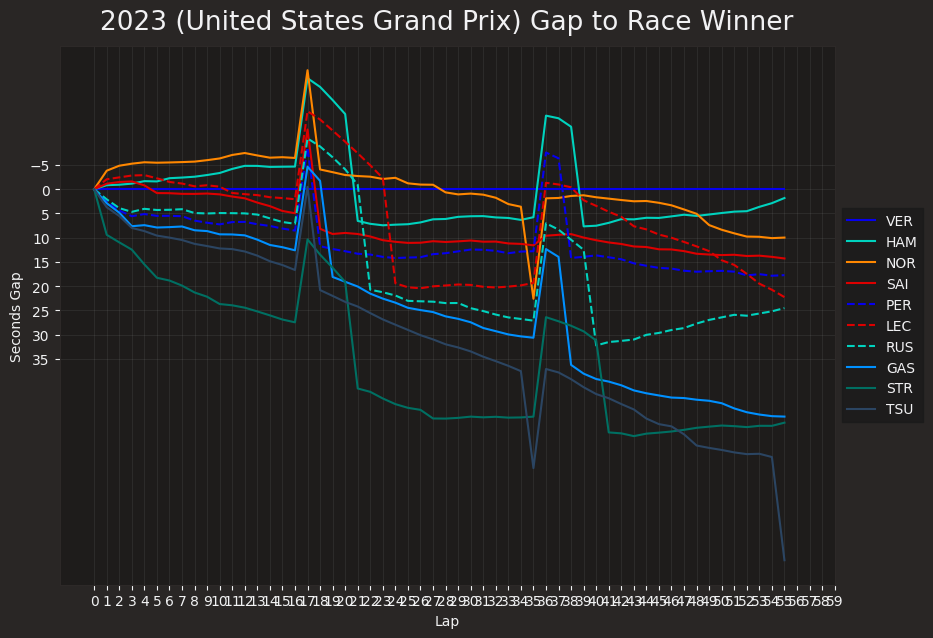

In [13]:
#getting the winner 
winner = drivers[0]

#making a new variable called delta_time which contain all laps with limited columns 
delta_time = laps[["DriverNumber","Driver","LapNumber","LapStartTime","LapStartTimeS","DeltaTime"]] 
delta_time["LapNumber"] = delta_time["LapNumber"] -1
# loop to calculate race gap to race winner
for i in drivers:
    #calculate the difference between race winner and other drivers on the laps Start Time Seconds 
    gap = delta_time.loc[delta_time["DriverNumber"] == i,["LapStartTimeS"]].reset_index() - delta_time.loc[delta_time["DriverNumber"] == winner,["LapStartTimeS"]].reset_index()
    #Drop NAN values
    gap = gap.dropna(subset=['LapStartTimeS'])
    #affect a list of gap values to the driver on the column DeltaTime which was 0 
    delta_time.loc[delta_time["DriverNumber"] == i, "DeltaTime"] = gap["LapStartTimeS"].values # list of gap for all laps 

#loading data    
safetycardata = laps.pick_driver(winner)
#loading only safety car laps
safetycar = safetycardata.loc[safetycardata["TrackStatus"].str.contains('4'),['LapNumber','TrackStatus']].reset_index(drop=True)
#loading only Virstual safety car laps
Vsafetycar = safetycardata.loc[safetycardata["TrackStatus"].str.contains('6'),['LapNumber','TrackStatus']].reset_index(drop=True)

# Plot the graph

plt.figure(figsize=(10, 7))
color_picked = []

max_gap = 0
min_gap = 0
for i in drivers[:10]:
# for i in drivers:
    x = delta_time.loc[delta_time["DriverNumber"]==i,"LapNumber"]
    y = delta_time.loc[delta_time["DriverNumber"]==i,"DeltaTime"]
    driver_name = session.get_driver(i)["Abbreviation"]
    team_color = fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
    
    if team_color in color_picked:
        plt.plot(x, y, color=team_color, linestyle='dashed', label=driver_name)
    else:    
        plt.plot(x, y, color=team_color, linestyle='solid', label=driver_name)
        color_picked.append(team_color)
    # if (max_gap < y.max().values[0]):
    #     max_gap = int(y.max().values[0])+10
    # if (min_gap > y.min().values[0]):
    #     min_gap = int(y.min().values[0]) - (10+int(y.min().values[0]))

# Customize the plot
plt.title('2023 ('+race_name+') Gap to Race Winner')
plt.xlabel('Lap')
plt.ylabel('Seconds Gap')
plt.xticks(range(0, max_lap_race+4, 1))
plt.yticks(range(-5, 40, 5))
plt.gca().invert_yaxis()

#Safety car zone
SC = Safety_car(safetycar)
VSC = Safety_car(Vsafetycar)
for i in range(0,len(SC)):
    plt.axvspan(SC[i][0], SC[i][1], facecolor='yellow', alpha=0.3, label = 'SC')
for i in range(0,len(VSC)):
    plt.axvspan(VSC[i][0], VSC[i][1], facecolor='orange', alpha=0.3, label = 'VSC')

# plt.fill_between([14, 15],-10,80, color='Orange', alpha=0.3, label='VSC')

# Hide tick labels for minor ticks

# Add grid
plt.grid(True, alpha=0.1)



# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.savefig('C:/Users/GTR/Pictures/Graphes/Race/2023_'+race_name+'_GapRaceWinner.png', dpi=200, bbox_inches='tight')
plt.show()



### Tires Strategy

C:\Users\GTR\AppData\Local\Temp\ipykernel_5108\997876957.py:20: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.8.
  plt.barh(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


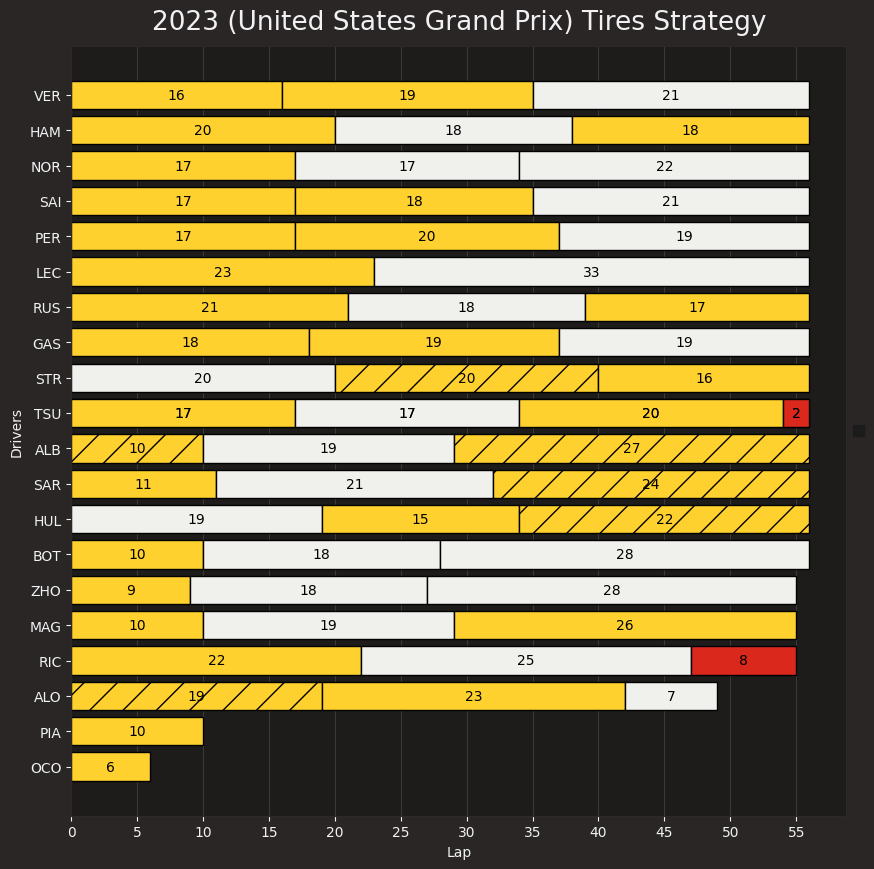

In [14]:
# getting all laps with 4 columns only to variable stints 
stints = laps[["Driver", "Stint", "Compound", "LapNumber","FreshTyre"]]
# grouping by Driver Stint Compound to calculate the number of laps of each stint
stints = stints.groupby(["Driver", "Stint", "Compound","FreshTyre"])
stints = stints.count().reset_index()
# stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.rename(columns={"LapNumber": "StintLength"})

# Plotting the stints
fig, ax = plt.subplots(figsize=(10, 10))

for driver in drivers_abr:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars
        hatch_pattern = '/' if row['FreshTyre'] == False else ' '  # Define the condition for the hatch pattern
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=compoundcolor.loc[compoundcolor["Compound"]==row["Compound"],"CompoundColor"],
            edgecolor="black",
            fill=True,
            hatch=hatch_pattern
        )

        # Add the value over the bar
        plt.text(
            x=previous_stint_end + row["StintLength"] / 2,
            y=driver,
            s=str(row["StintLength"]),
            ha='center',
            va='center',
            color='black'  # Set text color to black
        )

        previous_stint_end += row["StintLength"]
# plt.fill_between([20, 22],-0.5,18, color='blue', alpha=0.3, label='Interval')
# plt.fill_between([44, 45],-0.5,18, color='blue', alpha=0.3, label='Interval')

#Safety car zone
labelsc = 'SC'
labelvsc = 'VSC'
for i in range(0,len(SC)):
    plt.axvspan(SC[i][0], SC[i][1], facecolor='purple', alpha=0.5, label = labelsc)
    labelsc = ''
for i in range(0,len(VSC)):
    plt.axvspan(VSC[i][0], VSC[i][1], facecolor='orange', alpha=0.7, label = labelvsc)
    labelvsc = ''

# Customize the plot
plt.title('2023 (' + race_name + ') Tires Strategy')
plt.xlabel('Lap')
plt.ylabel('Drivers')
plt.xticks(range(0, max_lap_race+1, 5))
# plt.yticks(range(0, max_gap, 10))
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.axvspan(32, 38, facecolor='yellow', alpha=0.3)

# plt.savefig('Graphes/Race/Tires_Strategy.png', dpi=300)
plt.savefig('C:/Users/GTR/Pictures/Graphes/Race/2023_'+race_name+'_Tires_Strategy.png', dpi=300, bbox_inches='tight')

plt.show()



### Positions during the race

In [15]:
DRV["Position"] = [i for i in range(1,len(DRV)+1)]

In [16]:
results

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,HeadshotUrl,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points
0,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,#0600ef,red_bull,Max,Verstappen,Max Verstappen,https://www.formula1.com/content/dam/fom-websi...,NED,1.0,1,6.0,NaT,NaT,NaT,0 days 01:35:21.362000,Finished,25.0
1,44,L HAMILTON,HAM,hamilton,Mercedes,#00d2be,mercedes,Lewis,Hamilton,Lewis Hamilton,https://www.formula1.com/content/dam/fom-websi...,GBR,19.0,D,1.0,NaT,NaT,NaT,NaT,Disqualified,0.0
2,4,L NORRIS,NOR,norris,McLaren,#ff8700,mclaren,Lando,Norris,Lando Norris,https://www.formula1.com/content/dam/fom-websi...,GBR,2.0,2,2.0,NaT,NaT,NaT,0 days 00:00:10.730000,Finished,18.0
3,55,C SAINZ,SAI,sainz,Ferrari,#dc0000,ferrari,Carlos,Sainz,Carlos Sainz,https://www.formula1.com/content/dam/fom-websi...,ESP,3.0,3,4.0,NaT,NaT,NaT,0 days 00:00:15.134000,Finished,15.0
4,11,S PEREZ,PER,perez,Red Bull Racing,#0600ef,red_bull,Sergio,Perez,Sergio Perez,https://www.formula1.com/content/dam/fom-websi...,MEX,4.0,4,9.0,NaT,NaT,NaT,0 days 00:00:18.460000,Finished,12.0
5,16,C LECLERC,LEC,nan,Ferrari,#dc0000,nan,Charles,Leclerc,Charles Leclerc,https://www.formula1.com/content/dam/fom-websi...,MON,NaN,nan,NaN,NaT,NaT,NaT,NaT,nan,NaN
6,63,G RUSSELL,RUS,russell,Mercedes,#00d2be,mercedes,George,Russell,George Russell,https://www.formula1.com/content/dam/fom-websi...,GBR,5.0,5,5.0,NaT,NaT,NaT,0 days 00:00:24.999000,Finished,10.0
7,10,P GASLY,GAS,gasly,Alpine,#0090ff,alpine,Pierre,Gasly,Pierre Gasly,https://www.formula1.com/content/dam/fom-websi...,FRA,6.0,6,7.0,NaT,NaT,NaT,0 days 00:00:47.996000,Finished,8.0
8,18,L STROLL,STR,stroll,Aston Martin,#006f62,aston_martin,Lance,Stroll,Lance Stroll,https://www.formula1.com/content/dam/fom-websi...,CAN,7.0,7,0.0,NaT,NaT,NaT,0 days 00:00:48.696000,Finished,6.0
9,22,Y TSUNODA,TSU,tsunoda,AlphaTauri,#2b4562,alphatauri,Yuki,Tsunoda,Yuki Tsunoda,https://www.formula1.com/content/dam/fom-websi...,JPN,8.0,8,11.0,NaT,NaT,NaT,0 days 00:01:14.385000,Finished,5.0


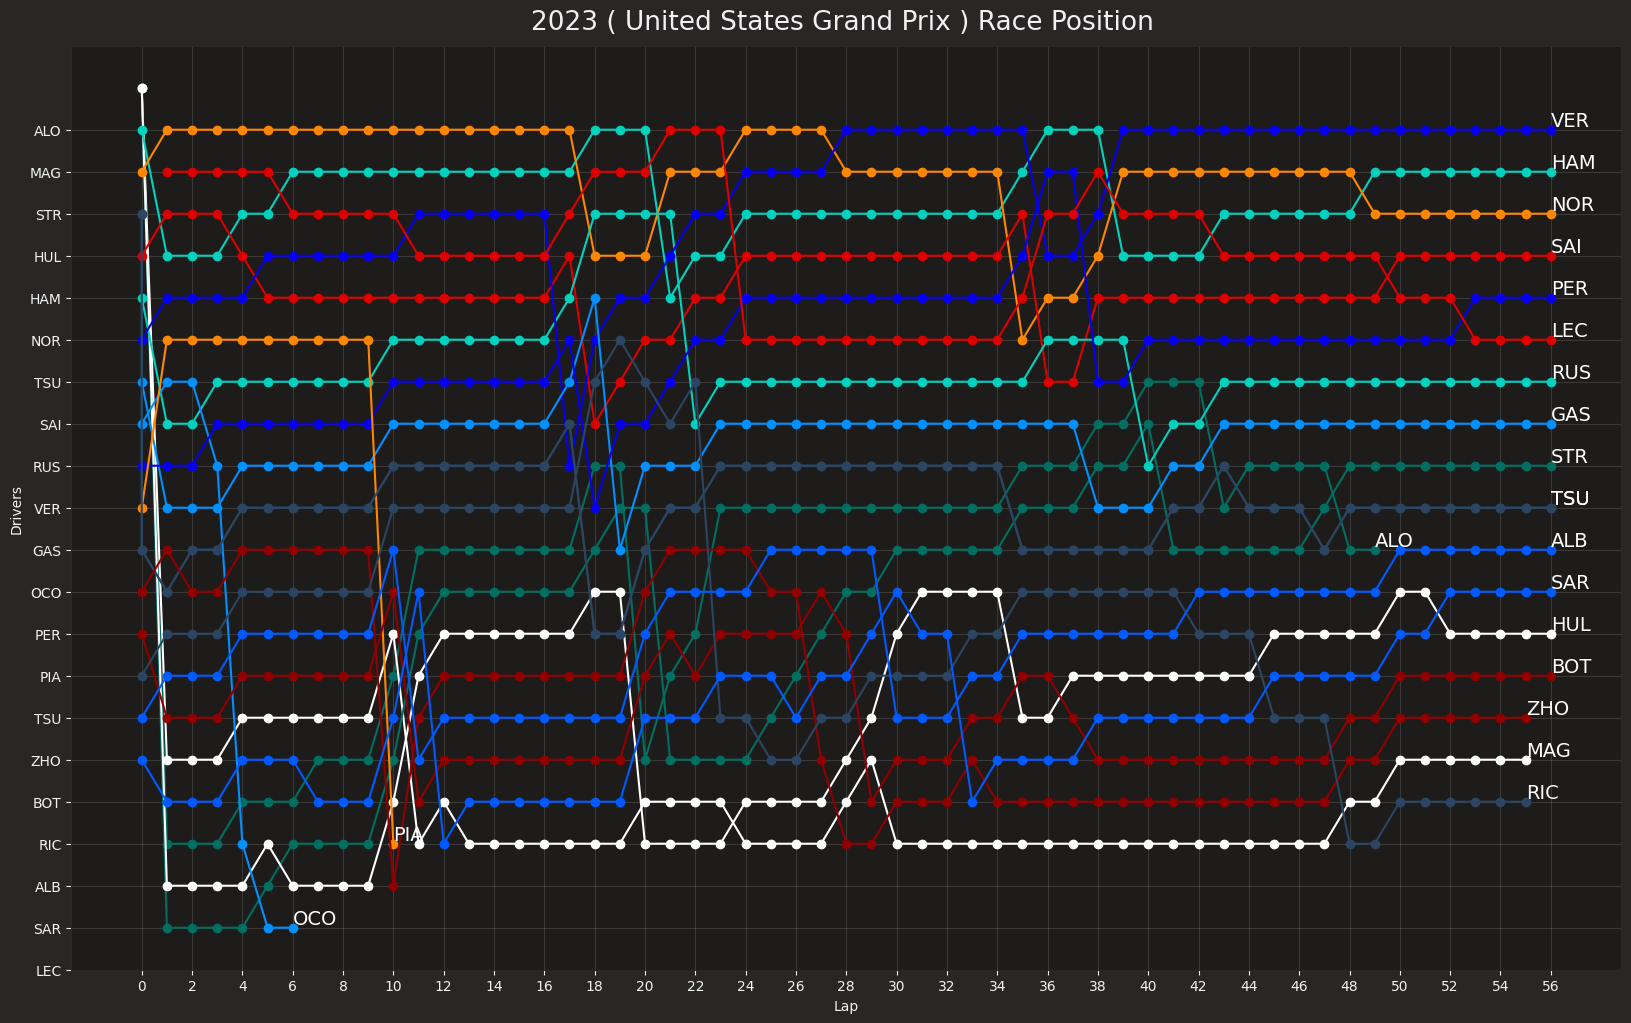

In [17]:
position_drivers = results[["DriverNumber","GridPosition"]].sort_values(by='GridPosition')
position_drivers = position_drivers.rename(columns={'GridPosition': 'Position'})
position_drivers["LapNumber"] = 0
Rest_laps = laps[["DriverNumber","Position","LapNumber"]].sort_values(by=['LapNumber']).reset_index(drop=True)
position_drivers = pd.concat([position_drivers, Rest_laps], ignore_index=True)

#ploting graph

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(20, 12))

# Plot each line with dots using a loop
for i in drivers_start:
    x = position_drivers.loc[position_drivers["DriverNumber"]== i,["LapNumber"]]
    y = position_drivers.loc[position_drivers["DriverNumber"]== i,["Position"]]
    color = fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
    # label = position_drivers.loc[(position_drivers["LapNumber"]== 1)&(position_drivers["DriverNumber"]== i),["Driver"]]
    ax.plot(x, y, marker='o', linestyle='-', color = color)
    plt.text(x.max().values[0],y.values[-1][0],session.get_driver(i)["Abbreviation"], ha='left', va='bottom',color='white',fontsize=14)


plt.title('2023 ( '+session.event["EventName"]+' ) Race Position ')
plt.xlabel('Lap')
plt.ylabel('Drivers')
plt.xticks(range(0, max_lap_race+2, 2))
plt.yticks(range(1, len(drivers_start_abr)+1),drivers_start_abr)
plt.gca().invert_yaxis()


# Add a legend
plt.grid(True, alpha=0.2)
# ax.legend()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig('Graphes/Race/RacePosition.png', dpi=300)
plt.savefig('C:/Users/GTR/Pictures/Graphes/Race/2023_'+race_name+'_RacePosition.png', dpi=300, bbox_inches='tight', transparent=True)
# Show the plot
plt.show()


### Race Pace 

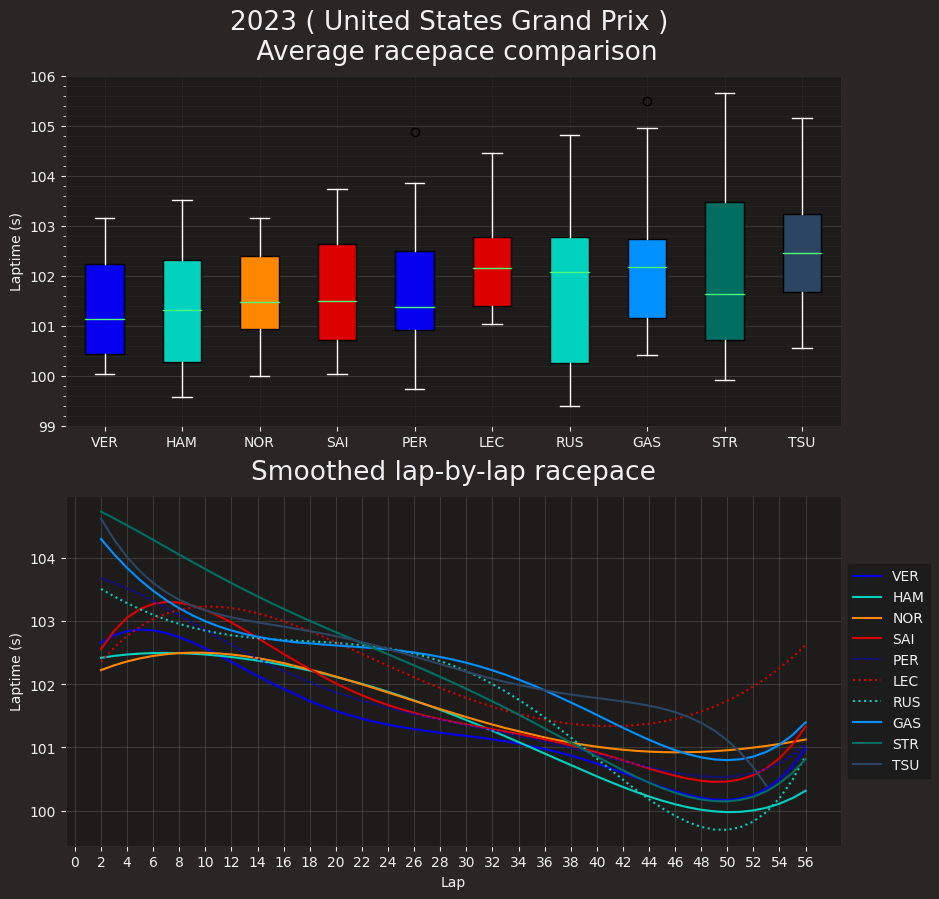

In [18]:
# To get accurate laps only, we exclude in- and outlaps
laps_pace = laps.loc[(laps['PitOutTime'].isnull() & laps['PitInTime'].isnull())]
# Also, we remove outliers since those don't represent the racepace,
# using the Inter-Quartile Range (IQR) proximity rule
q75, q25 = laps_pace['LapTimeS'].quantile(0.75), laps_pace['LapTimeS'].quantile(0.25)

intr_qr = q75 - q25

laptime_max = q75 + (1.5 * intr_qr) # IQR proximity rule: Max = q75 + 1,5 * IQR
laptime_min = q25 - (1.5 * intr_qr) # IQR proximity rule: Min = q25 + 1,5 * IQR

laps_pace.loc[laps_pace['LapTimeS'] < laptime_min, 'LapTimeS'] = np.nan
laps_pace.loc[laps_pace['LapTimeS'] > laptime_max, 'LapTimeS'] = np.nan


# drivers abreviation list
drivers_to_visualize = drivers_abr[:10]

# drivers average lap DataFrame
# drivers= results['Abbreviation']
# y axis max and min values
max_time = int(laps_pace["LapTimeS"].max())+1
min_time = int(laps_pace["LapTimeS"].min())-1

# Ploting Graph


visualized_teams = []

fig, ax = plt.subplots(2, figsize=[10, 10])

##############################
#
# Boxplot for average racepace
#
##############################
laptimes = [laps_pace.pick_driver(x)['LapTimeS'].dropna() for x in drivers_to_visualize] 

# Create a list of colors for each boxplot

# Create the boxplot with custom colors
boxplot = ax[0].boxplot(laptimes, labels=drivers_to_visualize, patch_artist=True)

# Set the colors for each boxplot
for box, color in zip(boxplot['boxes'],results["TeamColor"]):
    box.set(facecolor=color)  # Set the face color of the box

# Set the line color to white
for whisker, cap in zip(boxplot['whiskers'], boxplot['caps']):
    whisker.set(color='white')
    cap.set(color='white')
    
# Set the title and labels for the boxplot
ax[0].set_title('2023 ( '+race_name+' ) \n Average racepace comparison')
ax[0].set_ylabel('Laptime (s)')
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(base=0.2))
ax[0].grid(which='both',alpha=0.05)



# ##############################
# #
# # Lap-by-lap racepace comparison
# #
# ##############################
for driver in drivers_to_visualize:
    driver_laps = laps_pace.pick_driver(driver)[['LapNumber', 'LapTimeS', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeS'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=fastf1.plotting.team_color(team), linestyle=linestyle)
    
    # Include scatterplot (individual laptimes)
    # y = driver_laps['LapTimeS']
    # scatter_marker = 'o' if team not in visualized_teams else '^' 
    # ax[1].scatter(x, y, label=driver, color=ff1.plotting.team_color(team), marker=scatter_marker)
    
    # Append labels
    ax[1].set(ylabel = 'Laptime (s)')
    ax[1].set(xlabel = 'Lap')
    
    # Set title
    ax[1].set_title('Smoothed lap-by-lap racepace')

    # ax[1].set_xtrick(range(0,55),2)

    # Generate legend
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)

plt.xticks(range(0,int(session.laps["LapNumber"].max()+2), 2))
ax[0].grid(axis='y',alpha=0.2)
ax[0].set_yticks(range(min_time,200,1))
ax[0].set_ylim(min_time+1,int(laptime_max )+1)
ax[1].grid(True,alpha=0.2)
# plt.axvspan(32, 38, facecolor='yellow', alpha=0.3)
plt.savefig('C:/Users/GTR/Pictures/Graphes/Race/2023_'+race_name+'_RacePace_comparison.png', dpi=200)

### Average Top Speed

Driver DNF
Driver DNF


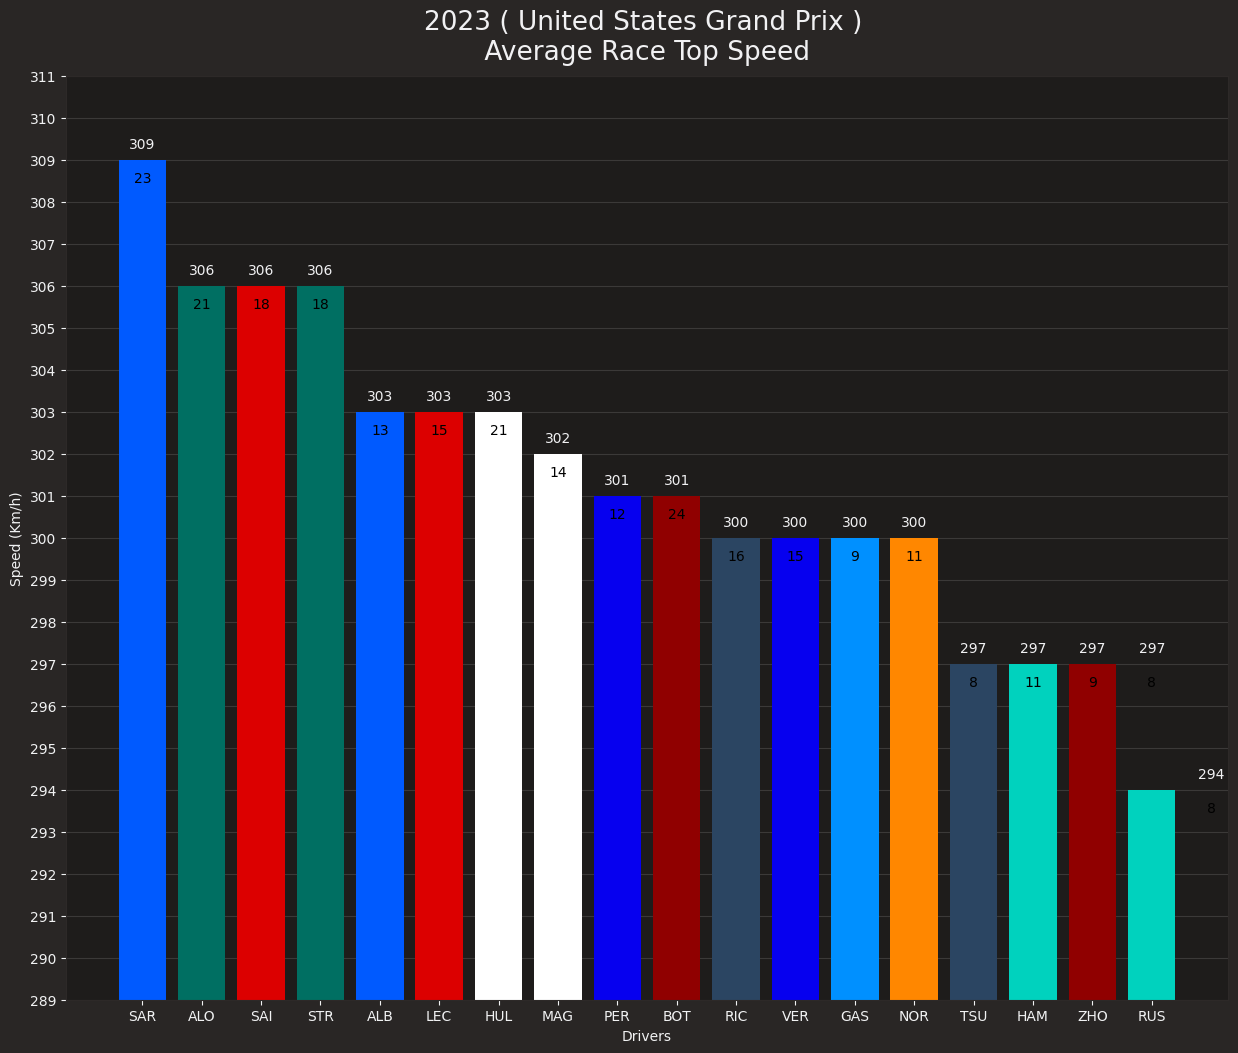

In [19]:
driver_list = []
DriverAB_list = []
top_speed_list = []
color_list = []
drs_list = []
        
for i in drivers:
    # check if driver has laps 
    if (laps.pick_driver(i).empty):
        print("The DataFrame is empty")

    #check if driver has completed at least 75% of the race
    elif(laps.loc[laps["DriverNumber"]==i,"LapNumber"].max()< max_lap_race*0.75):
        print("Driver DNF")
    #calculating Average top speed
    else:
        Avg_Top_Speed = [] # Reseting the list of max speed of each driver
        for j in range(0,max_lap_race+1):
            lap_i = laps.loc[(laps["LapNumber"]== j)&(laps["DriverNumber"]== i)]
            if(lap_i.empty != True):# if lap is not empty
                max_speed = lap_i.get_car_data()["Speed"].max()# get max speed of the lap (i)
                Avg_Top_Speed.append(max_speed)#append it to the list of max speed of each lap
        Top_Speed = mean(Avg_Top_Speed)#calculating the mean if the list of max speed of each lap
        lap = laps.pick_driver(i)
        drs = 0 # Reseting the list of Drs activation of each driver
        for j in range(0,len(lap)): # loop over all laps of the driver to calculate number of drs activation
            if((lap.iloc[j].get_car_data()["DRS"]!=0).any()): # Check if driver has used DRS in the lap
                drs += 1
        
        drs_list.append(drs)
        driver_list.append(i)
        DriverAB_list.append(results.loc[results["DriverNumber"] == i,"Abbreviation"].values[0])
        top_speed_list.append(Top_Speed)
        color_list.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))

df_top_speed = pd.DataFrame({
    'DriverNumber': driver_list,
    'Driver': DriverAB_list,
    'TopSpeed': top_speed_list,
    'Color': color_list,
    'DRS': drs_list
})

df_top_speed = df_top_speed.sort_values(by='TopSpeed', ascending=False).reset_index(drop=True)

# Ploting graph 

plt.figure(figsize=(15, 12))
x = df_top_speed["Driver"].reset_index(drop=True)
y = df_top_speed["TopSpeed"].reset_index(drop=True)
d = df_top_speed["DRS"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_top_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('Speed (Km/h)')
plt.title('2023 ( '+race_name+' ) \n Average Race Top Speed ')
plt.yticks(range(int(df_top_speed["TopSpeed"].min())-20, int(df_top_speed["TopSpeed"].max())+4,1))
plt.ylim(int(df_top_speed["TopSpeed"].min())-5,int(df_top_speed["TopSpeed"].max()) +2)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.2, str(y.loc[i]), ha='center', va='bottom')

# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]-0.6, str(d.loc[i]), ha='center', va='bottom',color='black')
    
plt.grid(axis='y', alpha=0.2)

plt.savefig('C:/Users/GTR/Pictures/Graphes/Race/2023_'+race_name+'_Average_race_top_speed.png', dpi=200, bbox_inches='tight')
# Display the plot
plt.show()

### Average Speed

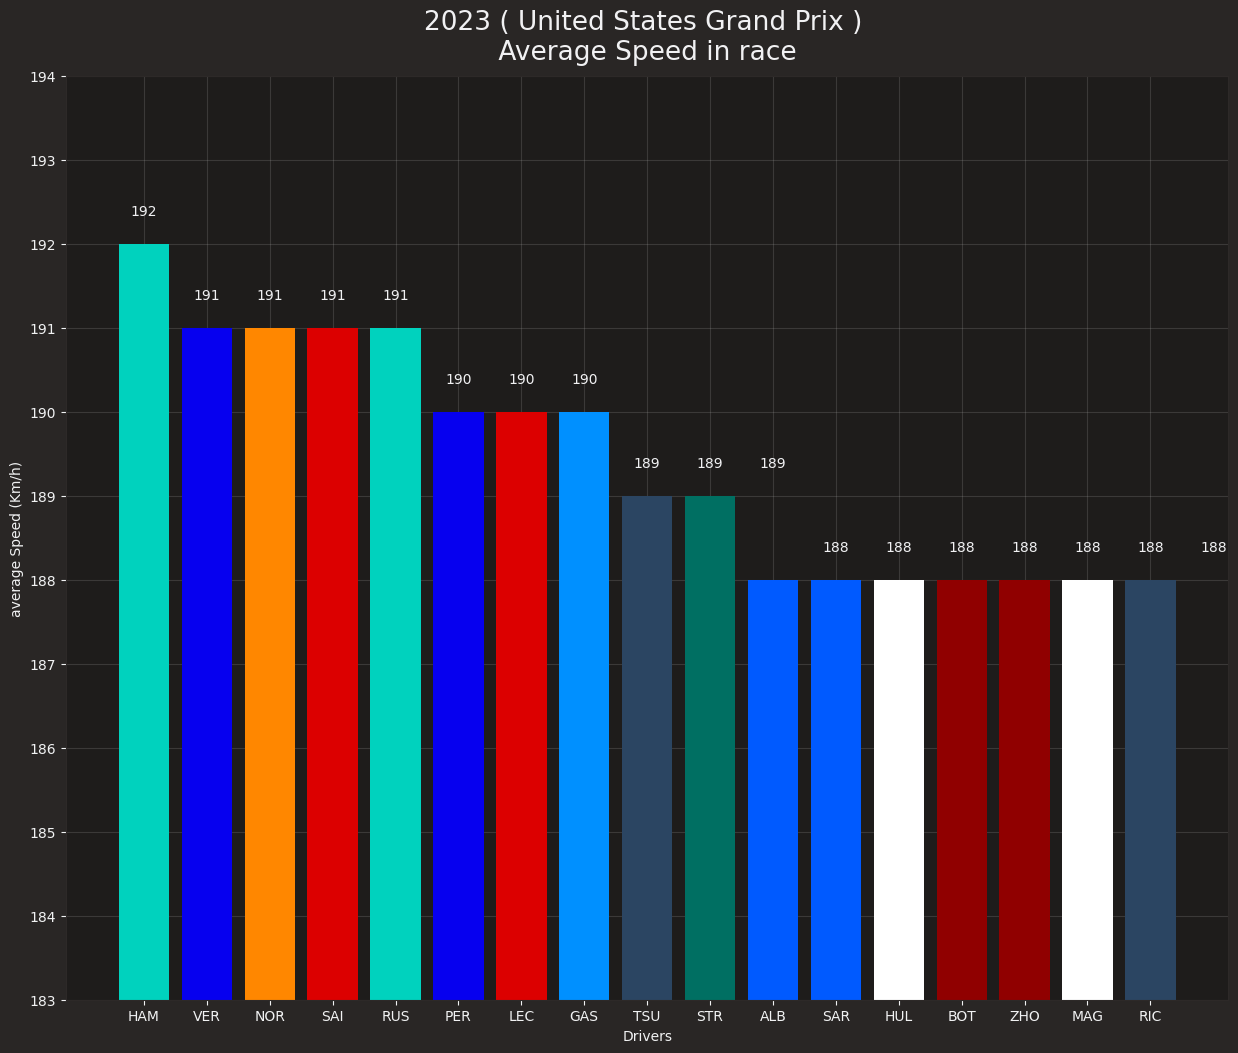

In [20]:
driver_list = []
DriverAB_list = []
avg_speed_list = []
color_list = []
df_avg_speed = pd.DataFrame()
for i in drivers:
    if laps.pick_driver(i).empty:
        print("The DataFrame is empty")
    #check if driver has completed at least 75% of the race
    elif(int(laps.loc[laps["DriverNumber"]==i,"LapNumber"].max())> max_lap_race*0.90):
        max_speed = laps.pick_driver(i).get_car_data()
        driver_list.append(i)
        DriverAB_list.append(results.loc[results["DriverNumber"] == i,"Abbreviation"].values[0])
        avg_speed_list.append(round(max_speed["Speed"].mean()))
        color_list.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))

df_avg_speed = pd.DataFrame({
    'DriverNumber': driver_list,
    'Driver': DriverAB_list,
    'AvgSpeed': avg_speed_list,
    'Color': color_list,
})

df_avg_speed = df_avg_speed.sort_values(by='AvgSpeed', ascending=False).reset_index(drop=True)

# Ploting graph

plt.figure(figsize=(15, 12))
x = df_avg_speed["Driver"].reset_index(drop=True)
y = df_avg_speed["AvgSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_avg_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('average Speed (Km/h)')
plt.title('2023 ( '+race_name+' ) \n Average Speed in race ')
plt.yticks(range(0, 350, 1))
plt.ylim(y.min()-5, y.max()+2)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.3, str(y.loc[i]), ha='center', va='bottom')

plt.grid(True, alpha=0.2)

plt.savefig('C:/Users/GTR/Pictures/Graphes/Race/2023_'+race_name+'_Average_race_speed.png', dpi=200, bbox_inches='tight')

# Display the plot
plt.show()

### Tire comparaison 

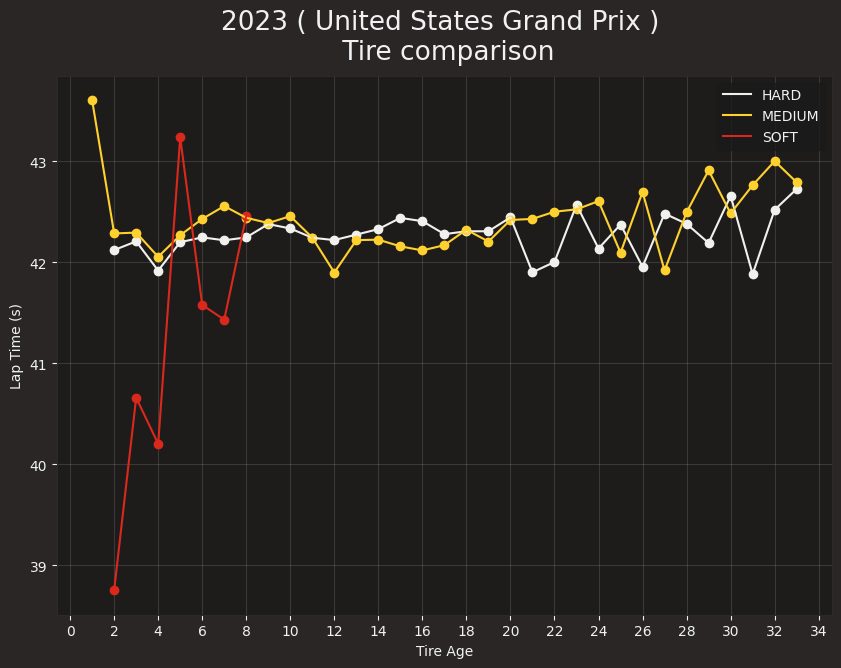

In [21]:
tire_comp = laps.pick_quicklaps()
for i in drivers:
    if tire_comp.loc[tire_comp["DriverNumber"]==i,"LapNumber"].max() < 17:
        tire_comp = tire_comp.drop(tire_comp.loc[tire_comp["DriverNumber"]==i].index)
tire_comp = tire_comp.groupby(["Compound","TyreLife"])["LapTimeS"].mean().reset_index()
tire_comp = pd.merge(tire_comp, compoundcolor, on='Compound')
tire_comp["LapTimeS"] -= 60
# Plotting graph
plt.figure(figsize=(10, 7))

for i in tire_comp["Compound"].unique():
    x = tire_comp.loc[tire_comp["Compound"]==i,["TyreLife"]]
    y = tire_comp.loc[tire_comp["Compound"]==i,["LapTimeS"]]
    plt.scatter(x,y, color=tire_comp.loc[tire_comp["Compound"]==i,"CompoundColor"].values[0])
    plt.plot(x,y, label=i, color=tire_comp.loc[tire_comp["Compound"]==i,"CompoundColor"].values[0])
# Add labels and title
plt.xlabel('Tire Age')
plt.ylabel('Lap Time (s)')
plt.title('2023 ( '+race_name+' ) \n Tire comparison')
plt.xticks(range(0, 36, 2))
plt.legend()
plt.grid(True, alpha=0.2)

plt.savefig('C:/Users/GTR/Pictures/Graphes/Race/2023_'+race_name+'_Tire_Comparaison.png', dpi=200, bbox_inches='tight')

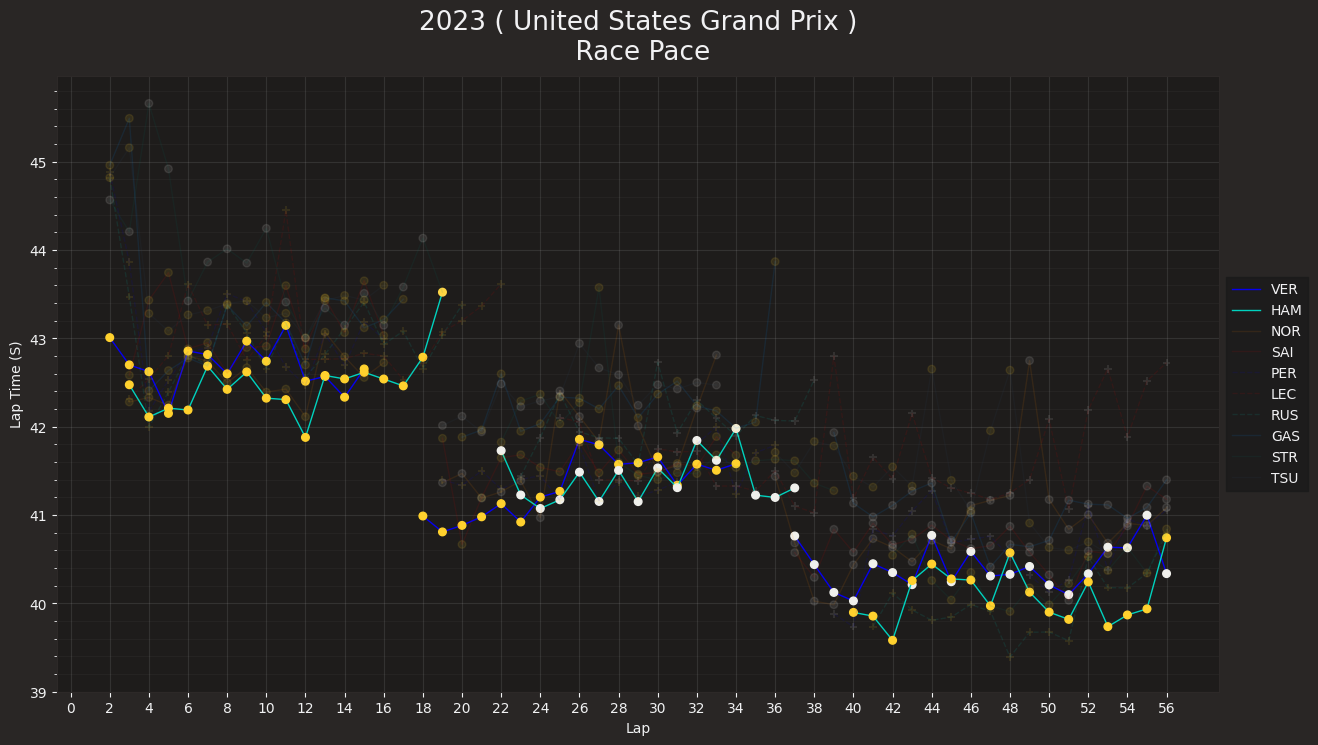

In [22]:
fig, ax = plt.subplots(1,1,figsize=(15, 8))

color_picked = []
laps_session = session.laps.pick_wo_box()
laps_session = laps_session[["DriverNumber","Driver","LapNumber","LapStartDate","Compound","LapTime","TyreLife","Stint"]]
laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
laps_session["LapStartDate"] = pd.to_datetime(laps_session["LapStartDate"])
laps_session["LapStartDateM"] = laps_session["LapStartDate"].dt.strftime('%H:%M')
laps_session = pd.merge(laps_session, compoundcolor, on='Compound')
session_time = laps_session["LapStartDate"].values[0]
new_session_time = session_time + pd.Timedelta(minutes=0)
top_drivers = drivers[:10]
selected_drivers = ['1','44']
for i in top_drivers:
    lap_ordred = laps_session.loc[(laps_session["DriverNumber"] == i)&(laps_session["LapStartDate"] >= new_session_time)].sort_values(by='LapStartDateM', ascending=True)
    lap_ordred["LapTimeS"] = lap_ordred["LapTimeS"] - 60
    # lap_ordred = lap_ordred.loc[lap_ordred["LapTimeS"] <= 46]

    driver_name = session.get_driver(i)["Abbreviation"]
    team_color =  fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
    for j in lap_ordred["Stint"].unique():
        if len(lap_ordred.loc[lap_ordred["Stint"] == j]) >2:
            x = lap_ordred.loc[lap_ordred["Stint"] == j,"LapNumber"]
            y = lap_ordred.loc[lap_ordred["Stint"] == j,"LapTimeS"]
            marker_color = lap_ordred.loc[lap_ordred["Stint"] == j,"CompoundColor"]
            if i in selected_drivers:
                alpha = 1
            else:
                alpha = 0.1
            if team_color in color_picked:
                plt.plot(x, y, color=team_color, label=driver_name, linestyle='--', linewidth=1 , alpha=alpha)
                plt.scatter(x, y, color=marker_color, marker='+', s=30, zorder=2, alpha=alpha)

            else:    

                plt.plot(x, y, color=team_color, label=driver_name , linewidth=1, alpha=alpha)
                plt.scatter(x, y, color=marker_color, marker='o', s=30, zorder=2, alpha=alpha)   

            driver_name = ""
    color_picked.append(team_color)


# Customize the plot
plt.title('2023 ( '+session.event["EventName"]+' )\n '+session_name+' Pace')
plt.xlabel('Lap')
plt.xticks(range(0, max_lap_race+1, 2))
plt.ylabel('Lap Time (S)')

plt.yticks(range(39,46, 1))
# plt.ylim(37,40)

ax = plt.gca()
# ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.2))
ax.grid(which='both',alpha=0.05)

plt.grid(True, alpha=0.15)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.savefig('C:/Users/GTR/Pictures/Graphes/Race/2023_'+race_name+'_'+session_name+'_pace.png', dpi=200, bbox_inches='tight')
# Display the plot
plt.show()


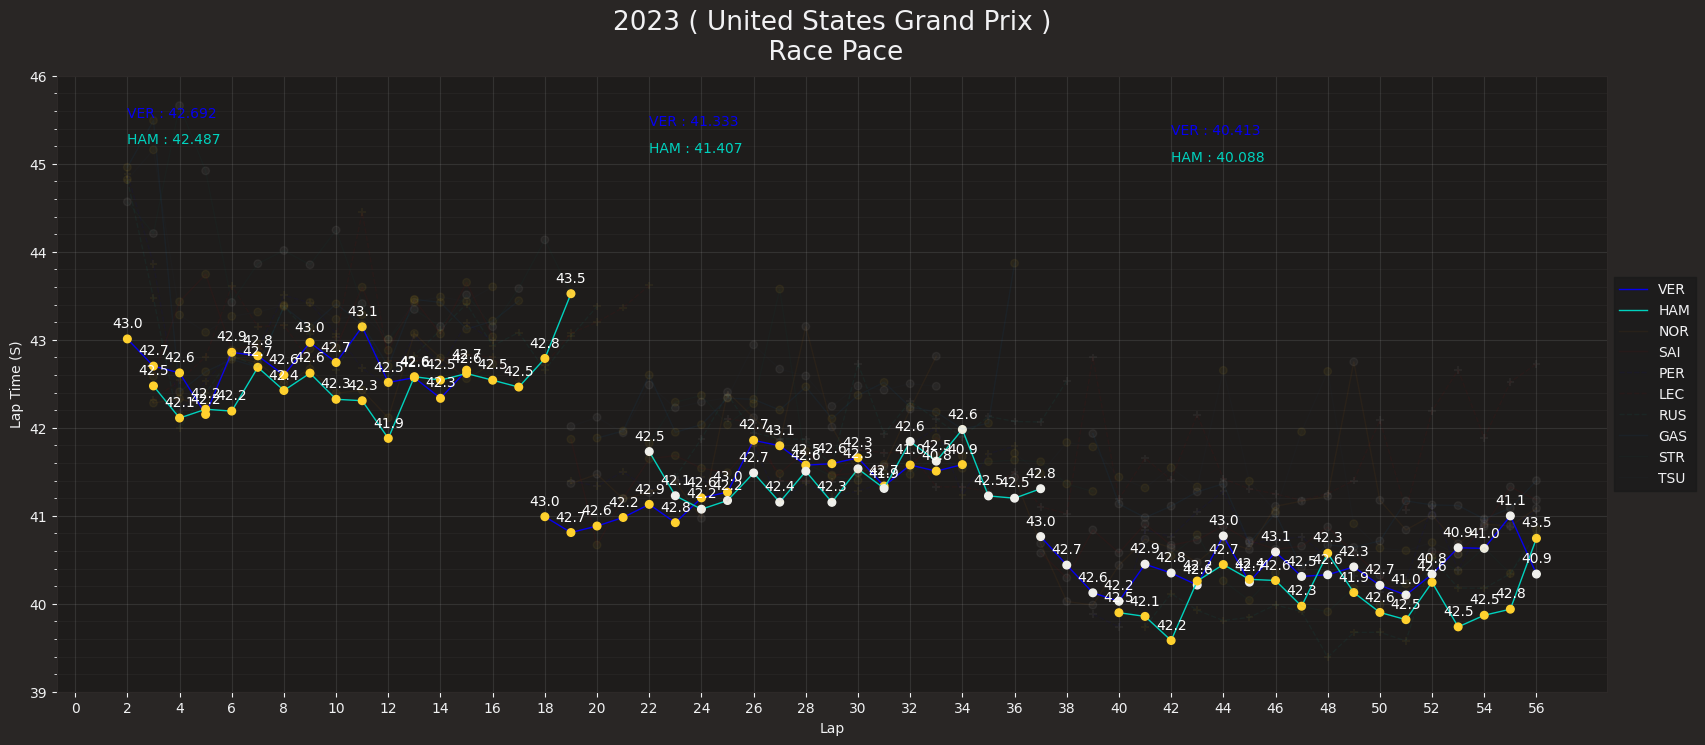

In [23]:
fig, ax = plt.subplots(1,1,figsize=(20, 8))

color_picked = []
laps_session = session.laps.pick_wo_box()
laps_session = laps_session[["DriverNumber","Driver","LapNumber","LapStartDate","Compound","LapTime","TyreLife","Stint"]]
laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
laps_session["LapStartDate"] = pd.to_datetime(laps_session["LapStartDate"])
laps_session["LapStartDateM"] = laps_session["LapStartDate"].dt.strftime('%H:%M')
laps_session = pd.merge(laps_session, compoundcolor, on='Compound')
session_time = laps_session["LapStartDate"].values[0]
new_session_time = session_time + pd.Timedelta(minutes=0)
top_drivers = drivers[:10]
selected_drivers = ['1','44']
z=0
for i in top_drivers:
    compt = 0
    lap_ordred = laps_session.loc[(laps_session["DriverNumber"] == i)&(laps_session["LapStartDate"] >= new_session_time)].sort_values(by='LapStartDateM', ascending=True)
    lap_ordred["LapTimeS"] = lap_ordred["LapTimeS"] - 60
    # lap_ordred = lap_ordred.loc[lap_ordred["LapTimeS"] <= 46]

    driver_name = session.get_driver(i)["Abbreviation"]
    team_color =  fastf1.plotting.team_color(session.get_driver(i)["TeamName"])
    for j in lap_ordred["Stint"].unique():
        if len(lap_ordred.loc[lap_ordred["Stint"] == j]) >2:
            x = lap_ordred.loc[lap_ordred["Stint"] == j,"LapNumber"]
            y = lap_ordred.loc[lap_ordred["Stint"] == j,"LapTimeS"]
            marker_color = lap_ordred.loc[lap_ordred["Stint"] == j,"CompoundColor"]
            if i in selected_drivers:
                alpha = 1
            else:
                alpha = 0.05
            if team_color in color_picked:
                plt.plot(x, y, color=team_color, label=driver_name, linestyle='--', linewidth=1 , alpha=alpha)
                plt.scatter(x, y, color=marker_color, marker='+', s=30, zorder=2, alpha=alpha)
                # Add numeric values above each 
                if i in selected_drivers:
                    for xi, yi, label in zip(x, y+0.1, lap_ordred["LapTimeS"]):
                        plt.text(xi, yi, "{:.1f}".format(label), ha='center', va='bottom', color=team_color)
            else:    
                plt.plot(x, y, color=team_color, label=driver_name , linewidth=1, alpha=alpha)
                plt.scatter(x, y, color=marker_color, marker='o', s=30, zorder=2, alpha=alpha)
                if i in selected_drivers:
                    for xi, yi, label in zip(x, y+0.1, lap_ordred["LapTimeS"]):
                        plt.text(xi, yi, "{:.1f}".format(label), ha='center', va='bottom', color="white")
            driver_name = ""
        if i in selected_drivers:
            plt.text(2+compt, 45.5+z,session.get_driver(i)["Abbreviation"]+' : '+"{:.3f}".format(mean(y)), ha='left', va='bottom', color=team_color)
            z-=0.1
            compt+=20
    color_picked.append(team_color)


# Customize the plot
plt.title('2023 ( '+session.event["EventName"]+' )\n '+session_name+' Pace')
plt.xlabel('Lap')
plt.xticks(range(0, max_lap_race+1, 2))
plt.ylabel('Lap Time (S)')

plt.yticks(range(39,50, 1))
plt.ylim(39,46)

ax = plt.gca()
# ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.2))
ax.grid(which='both',alpha=0.05)

plt.grid(True, alpha=0.15)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('C:/Users/GTR/Pictures/Graphes/Race/2023_'+race_name+'_'+session_name+'_pace_2_Drivers.png', dpi=200, bbox_inches='tight')
# Display the plot
plt.show()


### Tire management

C:\Users\GTR\AppData\Local\Temp\ipykernel_5108\2951555237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps1["LapTimeS"] = laps1["LapTime"].dt.total_seconds()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


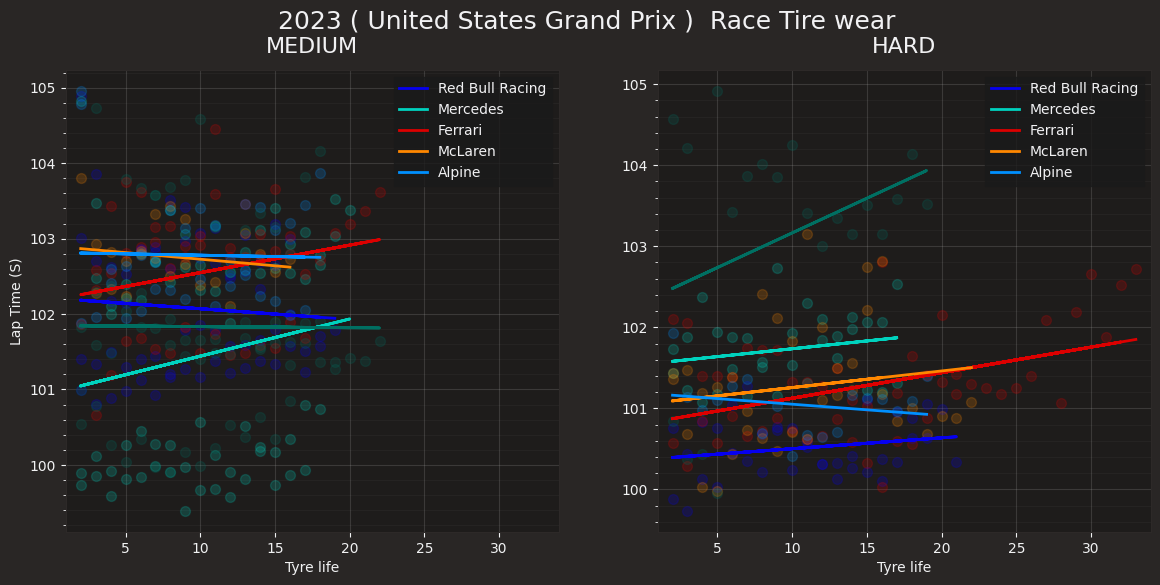

In [24]:
laps1 = session.laps.pick_wo_box()
laps1["LapTimeS"] = laps1["LapTime"].dt.total_seconds()
laps1 = laps1.loc[laps1["LapStartDate"] >= session_time].sort_values(by='LapStartDate', ascending=True)
laps1 = laps1.loc[laps1["Compound"] != "TEST_UNKNOWN"].reset_index(drop=True)
laps1 = laps1.loc[(laps1["LapTimeS"] >=50)&(laps1["LapTimeS"] <= 105)].reset_index(drop=True)

# Data for the teams
teams = laps1["Team"].unique()
teams = ['Red Bull Racing', 'Mercedes', 'Ferrari', 'McLaren', 'Alpine','Aston Martin']

# Create a figure and axis

exist = False
fig, ax = plt.subplots(1,2,figsize=(14, 6))
fig.suptitle('2023 ( '+session.event["EventName"]+' )  '+session_name+' Tire wear ', fontsize=18)
j=-1
# for i in laps1["Compound"].unique():
for i in ["MEDIUM","HARD"]:
    j=j+1
    ax[j].set_title(i, fontsize=16)
    ax[j].set_xlabel('Tyre life')
    # Loop through each team
    for team in teams:
        
        if (len(laps1.loc[(laps1["Team"] == team)&(laps1["Compound"] == i)])>5):
            exist = True
            x = laps1.loc[(laps1["Team"] == team)&(laps1["Compound"]==i), "TyreLife"]
            y = laps1.loc[(laps1["Team"] == team)&(laps1["Compound"]==i), "LapTimeS"]
            color = fastf1.plotting.team_color(team)
            ax[j].scatter(x, y, color=color, s=50 , alpha = 0.2)
            
            # Perform linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            ax[j].legend()
            # Create a regression line
            regression_line = slope * x + intercept

            # Plot the regression line
            ax[j].plot(x, regression_line, color=color, linestyle='-', linewidth=2, label=team)
    max_lap = int(laps1.loc[laps1["Compound"] == i,"TyreLife"].max()+1)
    min_lap = int(laps1.loc[laps1["Compound"] == i,"TyreLife"].min()-1)
    ax[j].grid(True, alpha=0.2)
    # ax[j].set_xticks(range(min_lap, max_lap, 5))
    ax[j].yaxis.set_minor_locator(ticker.MultipleLocator(base=0.2))
    ax[j].grid(which='minor',alpha=0.05)

    # ax[j].set_yticks(range(99, 104, 1))
    ax[j].set_xlim(min_lap, max_lap)

ax[0].set_ylabel('Lap Time (S)')

plt.savefig('C:/Users/GTR/Pictures/Graphes/Race/TiresManagment_'+session.event["Session"+str(ses)]+'.png', dpi=200, bbox_inches='tight')

plt.show()


### Telemetry by lap

In [25]:
driver = ['1', '16', '44']
laps_driver = []
fastest_driver = []
telemetry_driver = []
team_driver = []
delta_time = []
max_delta_time = 0
for i in range(0,len(driver)):
    laps_driver.append(laps.pick_driver(driver[i]))
    fastest_driver.append(laps_driver[i].pick_fastest())
    telemetry_driver.append(fastest_driver[i].get_telemetry())
    team_driver.append(fastest_driver[i]['Team'])

for i in range(1,len(driver)):
    delta_time1, Distance  = calculate_delta_times(telemetry_driver[0], telemetry_driver[i])
    if (max_delta_time < delta_time1.max()):
        max_delta_time = delta_time1.max()
    delta_time.append(delta_time1)

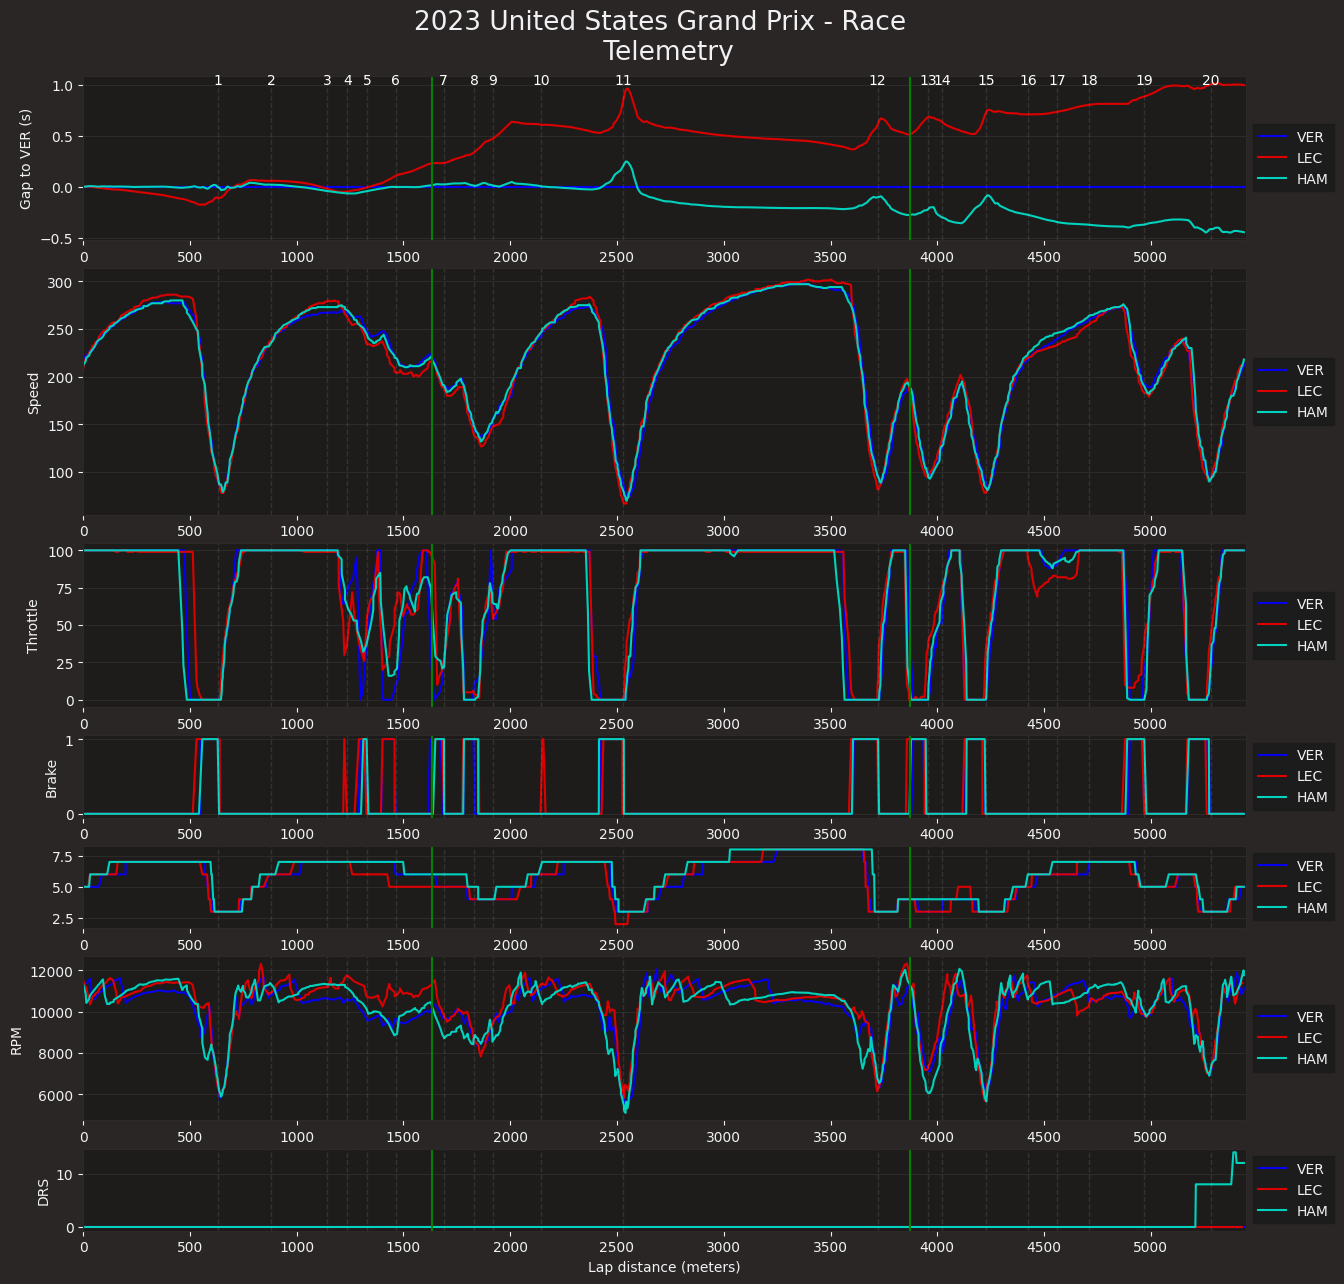

In [26]:

# plt.style.use("cyberpunk")
plot_size = [15, 15]
plot_title = f"{session.event.year} {session.event.EventName} - {session.name} \n Telemetry"
plot_ratios = [ 2, 3, 2, 1, 1, 2, 1]

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = plot_size

# Create subplots with different sizes
fig, ax = plt.subplots(7, gridspec_kw={'height_ratios': plot_ratios})

#Delta line
ax[0].axhline(0,label=session.get_driver(driver[0])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[0]))
# Delta time to first driver
for i in range(0,len(driver)-1):
    ax[0].plot(Distance, delta_time[i], label=session.get_driver(driver[i+1])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[i+1]))
# ploting other graphes
for i in range(0,len(driver)):
    ax[1].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['Speed'], label=session.get_driver(driver[i])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[i]))
    ax[2].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['Throttle'], label=session.get_driver(driver[i])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[i]))
    ax[3].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['Brake'], label=session.get_driver(driver[i])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[i]))
    ax[4].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['nGear'], label=session.get_driver(driver[i])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[i]))
    ax[5].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['RPM'], label=session.get_driver(driver[i])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[i]))
    ax[6].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['DRS'], label=session.get_driver(driver[i])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[i]))

# Set the plot title
ax[0].title.set_text(plot_title)
ax[0].set(ylabel=f"Gap to {session.get_driver(driver[0])['Abbreviation']} (s)")
ax[1].set(ylabel='Speed')
ax[1].legend(loc="lower right")
ax[2].set(ylabel='Throttle')
ax[3].set(ylabel='Brake')
ax[5].set(ylabel='RPM')
ax[6].set(ylabel='DRS')
ax[6].set(xlabel='Lap distance (meters)')


# Hide x labels and tick labels for top plots and y ticks for right plots.
# for a in ax.flat:
#     a.label_outer()
for i in range(0,7):
    ax[i].grid(axis = 'y',alpha = 0.1)
    ax[i].set_xticks(range(0, 8000, 500)) 
    ax[i].set_xlim(0, sector_distance[2]) 
    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i].axvline(x=sector_distance[0], color='green', linestyle='-')
    ax[i].axvline(x=sector_distance[1], color='green', linestyle='-')
    for j in range(0,len(corners_distance)):
        ax[i].axvline(x=corners_distance['Distance'][j], color='white', linestyle='--', linewidth=1, alpha=0.1)

for j in range(0,len(corners_distance)):
    ax[0].text(corners_distance['Distance'][j],max_delta_time+0.03,str(j+1), ha='center', va='center',color='white')
    
# Store figure
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/Telemetry'+session.event["Session"+str(ses)]+'.png', dpi=300, bbox_inches='tight')
plt.show()